In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import pickle
from collections import Counter
import os

In [2]:
# load the data into dataframe
df=pd.read_csv('energydata_complete.csv')
print(df.head())

                  date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   

   RH_out  Windspeed  Visibility

In [3]:
# print summary of dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [4]:
df.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [5]:
# check for duplicate values
duplicates=df.duplicated()
print(duplicates.sum())

0


In [6]:
# print the statistical summary of data set
print(df.describe())

         Appliances        lights            T1          RH_1            T2  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      97.694958      3.801875     21.686571     40.259739     20.341219   
std      102.524891      7.935988      1.606066      3.979299      2.192974   
min       10.000000      0.000000     16.790000     27.023333     16.100000   
25%       50.000000      0.000000     20.760000     37.333333     18.790000   
50%       60.000000      0.000000     21.600000     39.656667     20.000000   
75%      100.000000      0.000000     22.600000     43.066667     21.500000   
max     1080.000000     70.000000     26.260000     63.360000     29.856667   

               RH_2            T3          RH_3            T4          RH_4  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      40.420420     22.267611     39.242500     20.855335     39.026904   
std        4.069813      2.006111      3.254576    

In [26]:
df = df.sort_values(by='date').reset_index(drop=True)

In [27]:
from scipy.stats import zscore
df['zscore']=zscore(df['Appliances'])
df['is_outlier']=abs(df['zscore'])>3

outlier_number=df['is_outlier'].sum()
print(outlier_number)

540


In [28]:
def clip_outliers(df, col, lower=0.01, upper=0.99):
    q_low = df[col].quantile(lower)
    q_high = df[col].quantile(upper)
    df[col] = df[col].clip(q_low, q_high)
    return df

# Recommended features to clip
outlier_sensitive_cols = ['Appliances', 'lights']

for col in outlier_sensitive_cols:
    df = clip_outliers(df, col)

In [29]:
# rename the date column into 'timestamp'
df.rename(columns={'date':'timestamp'},inplace=True)

df['timestamp']=pd.to_datetime(df['timestamp'])

df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

df['nsm'] =( 
    df['timestamp'].dt.hour * 3600 +
    df['timestamp'].dt.minute * 60 +
    df['timestamp'].dt.second )

df['lag_1'] = df['Appliances'].shift(1)
df['lag_2'] = df['Appliances'].shift(2)
df['lag_6'] = df['Appliances'].shift(6)
df['lag_12'] =df['Appliances'].shift(12)

df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

#df['rolling_mean_6'] = df['Appliances'].shift(1).rolling(window=6).mean()
#df['rolling_std_6'] = df['Appliances'].shift(1).rolling(window=6).std()

df['rolling_mean_12'] = df['Appliances'].shift(1).rolling(window=12).mean()
df['rolling_std_12'] = df['Appliances'].shift(1).rolling(window=12).std()

#df['target_10min']= df['Appliances'].shift(-1)

df.rename(columns={'Appliances':'current_value'},inplace=True)



In [30]:
df=df.drop(columns=['timestamp','is_outlier','zscore','rv1','rv2'])

In [31]:
df.dropna(inplace=True)

# Save to CSV (WITHOUT target columns)
df.to_csv("feature_engineered_data.csv",index=False)
print("✅ Saved feature-engineered dataset to CSV (no targets).")

✅ Saved feature-engineered dataset to CSV (no targets).


In [32]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [33]:
# load the data into dataframe
data=pd.read_csv('feature_engineered_data.csv')
print(data.head())

   current_value  lights         T1       RH_1         T2       RH_2  \
0          430.0      30  20.133333  48.000000  19.566667  44.400000   
1          250.0      30  20.260000  52.726667  19.730000  45.100000   
2          100.0      10  20.426667  55.893333  19.856667  45.833333   
3          100.0      10  20.566667  53.893333  20.033333  46.756667   
4           90.0      10  20.730000  52.660000  20.166667  47.223333   

          T3       RH_3         T4       RH_4  ...  is_weekend    nsm  lag_1  \
0  19.890000  44.900000  19.000000  46.363333  ...           0  68400  576.6   
1  19.890000  45.493333  19.000000  47.223333  ...           0  69000  430.0   
2  20.033333  47.526667  19.000000  48.696667  ...           0  69600  250.0   
3  20.100000  48.466667  19.000000  48.490000  ...           0  70200  100.0   
4  20.200000  48.530000  18.926667  48.156667  ...           0  70800  100.0   

   lag_2  lag_6  lag_12  hour_sin  hour_cos  rolling_mean_12  rolling_std_12  
0  230.

In [ ]:
def select_features_for_step(data, step, n_features):
   
    # Copy data to avoid modifying original
    df = data.copy()


    # Create shifted target
    shift_steps = step // 10  # Assuming 10-min intervals
    target_col = f"target_{step}min"
    df[target_col] = df["current_value"].shift(-shift_steps)

        # Drop rows with NaN (from lag/rolling or shifting)
    df.dropna(inplace=True)

        # Define X and y
    X = df.drop(columns=[target_col])
    y = df[target_col]

        # Feature selection
    model = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=-1)
    selector = RFE(model, n_features_to_select=n_features,step=1)
    selector.fit(X, y)
        
    selected_features = X.columns[selector.support_].tolist()

    with open(f"selected_features_{step}min.pkl", "wb") as f:
        pickle.dump(selected_features, f)

    print(f"✅ Saved: selected_features_{step}min.pkl")
    return selected_features 


In [35]:
forecast_steps = [10, 20, 30, 40, 50, 60]
for step in forecast_steps:
    select_features_for_step(data, step, n_features=10)

✅ Saved: selected_features_10min.pkl
✅ Saved: selected_features_20min.pkl
✅ Saved: selected_features_30min.pkl
✅ Saved: selected_features_40min.pkl
✅ Saved: selected_features_50min.pkl
✅ Saved: selected_features_60min.pkl



✅ Selected features for 10 minutes:
['current_value', 'RH_5', 'T6', 'T8', 'RH_8', 'Press_mm_hg', 'nsm', 'lag_1', 'rolling_mean_12', 'rolling_std_12']

✅ Selected features for 20 minutes:
['current_value', 'RH_3', 'T4', 'RH_5', 'T6', 'RH_8', 'Press_mm_hg', 'nsm', 'rolling_mean_12', 'rolling_std_12']

✅ Selected features for 30 minutes:
['current_value', 'RH_2', 'T4', 'RH_5', 'T6', 'RH_8', 'Press_mm_hg', 'nsm', 'rolling_mean_12', 'rolling_std_12']

✅ Selected features for 40 minutes:
['current_value', 'T3', 'RH_5', 'T6', 'RH_8', 'Press_mm_hg', 'RH_out', 'nsm', 'rolling_mean_12', 'rolling_std_12']

✅ Selected features for 50 minutes:
['current_value', 'T3', 'RH_5', 'T6', 'RH_8', 'Press_mm_hg', 'Tdewpoint', 'nsm', 'rolling_mean_12', 'rolling_std_12']

✅ Selected features for 60 minutes:
['current_value', 'T3', 'RH_5', 'RH_8', 'T_out', 'Press_mm_hg', 'nsm', 'hour_cos', 'rolling_mean_12', 'rolling_std_12']


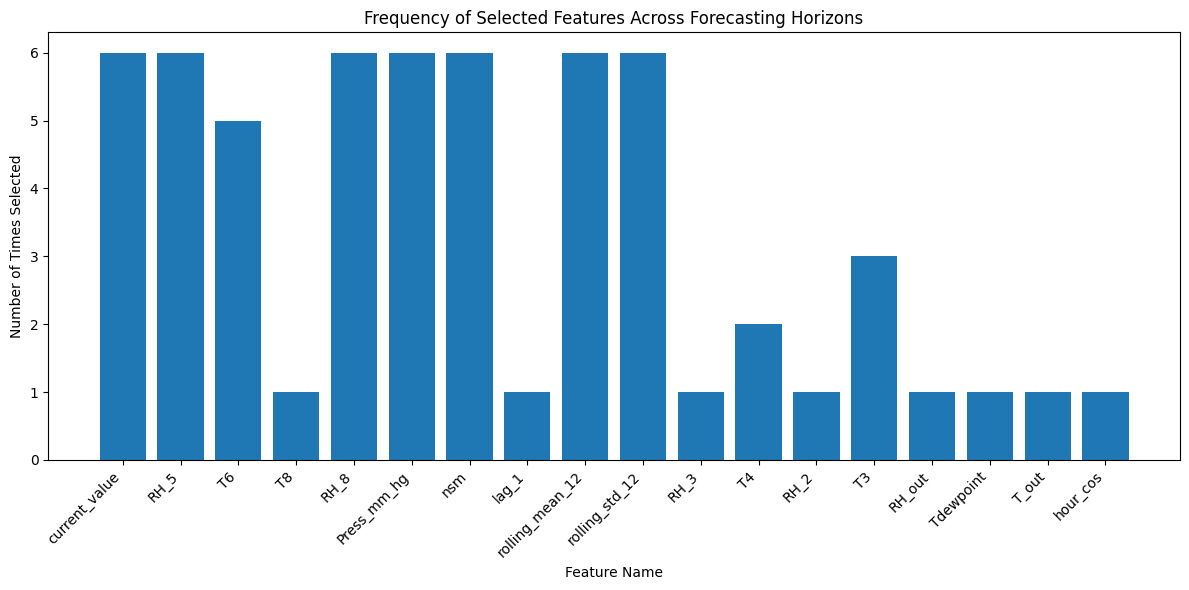

In [8]:
forecast_steps = [10, 20, 30, 40, 50, 60]
selected_features_all = []

# Load selected feature files and print them
for step in forecast_steps:
    filename = f"selected_features_{step}min.pkl"  # Adjust path if needed
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            features = pickle.load(f)
            selected_features_all.extend(features)
            print(f"\n✅ Selected features for {step} minutes:\n{features}")
    else:
        print(f"⚠️ File not found: {filename}")

# Count frequency of each feature across all steps
feature_counts = Counter(selected_features_all)

# Plot histogram of feature selection frequency
plt.figure(figsize=(12, 6))
plt.bar(feature_counts.keys(), feature_counts.values())
plt.title("Frequency of Selected Features Across Forecasting Horizons")
plt.xlabel("Feature Name")
plt.ylabel("Number of Times Selected")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()